# Covid 19 : India Analysis and Forecasting

## TO DO
1. Merge with COVID API DATA project to create end-end project. (Doing)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
from matplotlib import dates as dt
import datetime

plt.style.use('seaborn')

# 1. Grabbing Data

### A. Using Kaggle Challenge Dataset 
Stored Locally.

In [2]:
path_train = 'covid19-global-forecasting-week-4/train.csv'
path_test = 'covid19-global-forecasting-week-4/test.csv'
path_sbumit = 'covid19-global-forecasting-week-2/submission.csv'

train_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/train.csv'
test_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/test.csv'
submit_kaggle = '/kaggle/input/covid19-global-forecasting-week-2/submission.csv'

path_graphs = 'Graphs/'

In [3]:
df_train_count = pd.read_csv(path_train)
df_test_count = pd.read_csv(path_test)
df_train_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)
df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)

#### Helper Functions For Kaggle Dataset : 1. To filter DataFrame according to Country.

In [4]:
def country_df(country, df):
    """Filters a Dataframe according to Country.
    Args: 
    country: String. Name of country for which dataframe is to be filtered for.
    df: Dataframe. The Dataframe that is to be filtered.
    Returns: 
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    """
    if country != 'World':
        country_filt = (df['Country/Region'] == country)
        df_cases = df.loc[country_filt].groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.loc[country_filt].groupby(['Date'])['Fatalities'].sum()
    else:
        df_cases = df.groupby(['Date'])['ConfirmedCases'].sum()
        df_fatal = df.groupby(['Date'])['Fatalities'].sum()
    
    return df_cases, df_fatal

#### 2. To Prepare Model Train data.

In [5]:
def prepare_train_data(df_cases, df_fatal):
    """Splits ConfirmedCases and Fatalities dataframe into training features and labels.
    Args:
    df_cases: Dataframe. Filtered dataframe containing fields with confirmed Covid cases for the country.
    df_fatal: Dataframe. Filtered dataframe containing fileds with Covid fatalities for the country.
    Returns:
    x_train: np array. Array of integers denoting days since firstday of original df for model training features.
    y_cases: List. List of Confirmed Cases as labels for model from first day of original df.
    y_fatal: List. List of Fatalities as labels for model from first day of original df.
    """
    x_train = np.arange(0, len(df_cases)).reshape(-1,1)
    y_cases = df_cases.to_list()
    y_fatal = df_fatal.to_list()
   
    
    return x_train, y_cases, y_fatal


#### 3. For Plotting Actual and Predicted Metrics after modelling.

In [6]:
def plot_actual_predicted(country,label,  y_cases, y_pred, show_lockdown = False):
    """Plots the Actual and Predicted ConfirmedCases/Fatalities for a country.
    Args:
    country(string) country name.
    y_cases, y_pred (array/list) - Actual And Predicted Metrics.
    label(string) - Which metric is being passed.
    Returns:
    """
        
    xtick_locator = AutoDateLocator()
    xtick_formatter = AutoDateFormatter(xtick_locator)
    
    # generating dates using pandas, can be used with date_plot.
    train_times = pd.date_range(start = '2020-01-22', periods=len(y_cases))
    test_times = pd.date_range(start = '2020-01-22', periods=len(y_pred))
    dates = train_times.to_series().dt.date
    dates_test = test_times.to_series().dt.date

    # converting to Series, list 
    d_train = dates.tolist()
    d_test  = dates_test.tolist()
    
    # getting date_format variable for matplotlib and lockdown date.
    date_format = dt.DateFormatter('%b, %d')
    
    # converting lockdown date string to datetime.
    lockdown_date_str = '2020-03-25'
    lockdown_date = datetime.datetime.strptime(lockdown_date_str, '%Y-%m-%d')
    
    plt.style.use('seaborn')
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(17)
    fig.autofmt_xdate()
    ax.plot_date(d_train , y_cases, label = 'Actual Values', linestyle = 'solid', marker = None)
    ax.plot_date(d_test , y_pred , label = 'Predicted Values', linestyle = 'solid', marker = None)
    ax.set_title(f'{country} : {label} - Polynomial Regression (Degree = 6)')
    ax.set_ylabel(f'No of {label}')
    if show_lockdown:
        ax.axvline(lockdown_date, color = 'r', label='Lockdown')
    ax.xaxis.set_major_formatter(date_format)
    ax.legend()
    fig.savefig( path_graphs + f'{country}_conf_case.jpg')

### B. Getting Data Using Covid19India.org API
Fetches JSON from the Covid19.org API and creates dataframe of Daily and Total Cases, Recovered, Deceased.<br>
Testing data from Datameet ICMR backup JSON.

In [7]:
from india_API_data.Covid19_india_org_api import make_dataframe
from india_API_data.Covid19_india_org_api import get_test_dataframe

#### Helper Functions For API Data : 1. Plotting Metrics

In [8]:
def plot_daily(df, columns, save = False, log = False):
    """ Helper Function to Plot Current Metrics from API data.
    Args: 
    df (Dataframe) - Dataframe of API data create Using Make_dataframe.
    columns (List of column names)
    save(Bool) - Whether to save fig.
    Returns:
    """
    fig, ax = plt.subplots()
    fig.set_figheight(8)
    fig.set_figwidth(16)
    plt.style.use('seaborn')
    plt.title('Daily Trends: India (From API)')
    plt.ylabel('No. Of Individuals')
    plt.xlabel('Date')
    fig.autofmt_xdate()
    for item in columns:
        plt.plot_date(x = df.index, y= df[item], label = item, linestyle = 'solid', marker = None)
    plt.legend()
    if save!= False:
        fig.savefig(path_graphs + save + 'India_Cumulative_stats.png')
    #plt.yscale('log')
    plt.show()

# 2. Visualizations & Analysis


## Logistic Curve or S- shaped Curve : Comparing Epidemic Behaviour
<p>From the 3blue1brown video, epidemics are observed to follow a logistic curve. The no. of infected rises exponentially and reaches an inflection point before gradually decreasing. This can be somewhat seen in China's Confirmed Cases plot.</p>
![Image of Sigmoid](https://wikimedia.org/api/rest_v1/media/math/render/svg/9e26947596d387d045be3baeb72c11270a065665)
Here x0 = the x value of the sigmoids midpoint. <br>
L = the curve's maximum value. <br>
k = the logistic growth rate or steepness of the curve.

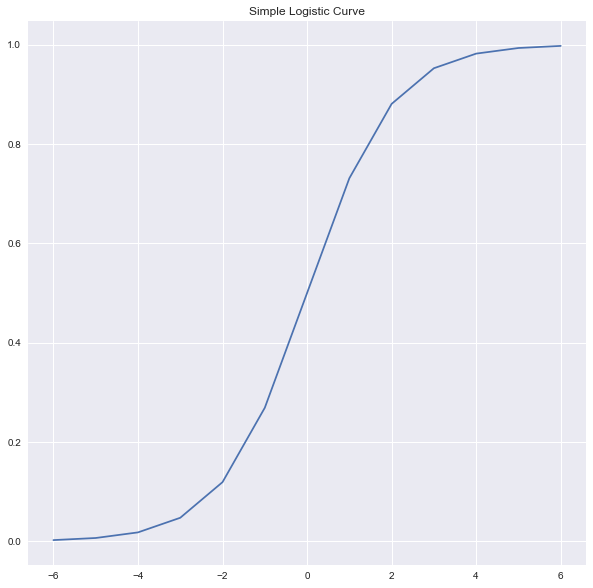

In [9]:
# Plotting a simple logistic curve using numpy and matplotlib.
# x = (-6,6), L =1, k = 1, x0 =0
x = np.arange(-6,7)
power = -1*x
y = 1 / (1 + np.exp(power))

plt.figure(figsize=(10,10))
plt.title('Simple Logistic Curve')
plt.grid(True)
plt.plot(x, y)
plt.show()

## This behaviour can be somewhat seen in the case of China

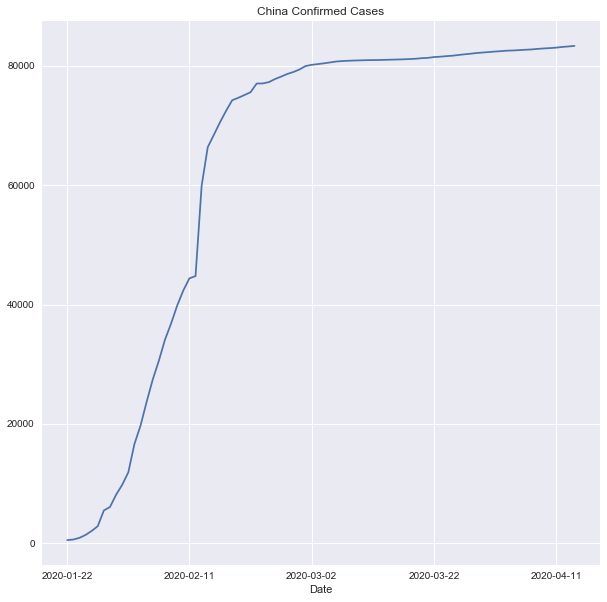

In [10]:
china_cases, china_fatal = country_df('China', df_train_count)
china_cases.plot(figsize = (10,10), title = 'China Confirmed Cases', grid = True)

## Worlwide Cases

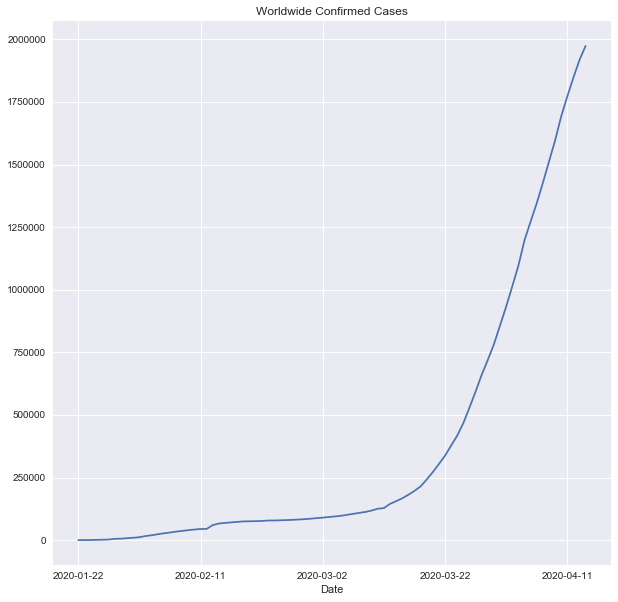

In [11]:
world_cases, world_fatal = country_df('World', df_train_count)
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases', grid = True)

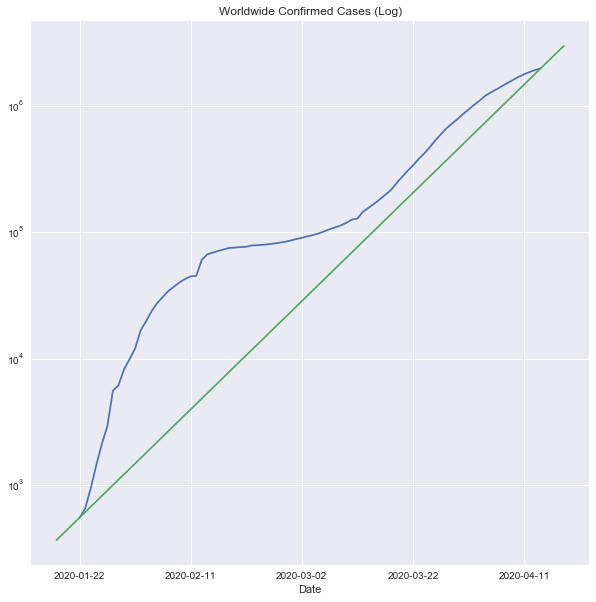

In [12]:
world_cases.plot(figsize = (10,10), title = 'Worldwide Confirmed Cases (Log)', grid = True, logy = True)
ax = plt.gca()
plt.plot([ax.get_xlim()[0],ax.get_xlim()[1]],[ax.get_ylim()[0],ax.get_ylim()[1]])
plt.show()

1. The Number of People getting infected is still growing, but to check whether it is growing exponentially we have to use the log scale.
2. The data plotted on the log Scale shows that the growth Seems to be touching the green line representing exponential growth. This could be a temporary Dip Before another wave and does not guarantee that the inflection point of the initial expoenential growth has been reached.

## India - Current Statistics

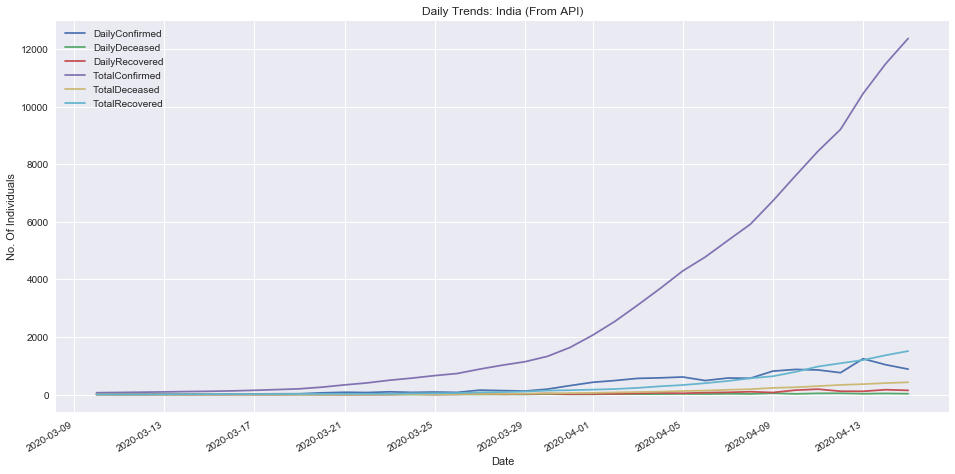

In [13]:
india_data = make_dataframe()
plot_daily(india_data.iloc[40:], india_data.columns.tolist(), save='All_stats_')

### India Testing Statistics
The comparison of the graphs of the amount of Testing Done and the confirmed Cases each day can be a good indicator of whether enough testing is being done. If the curves are very similar it can indicate that not enough people are getting tested.<br>
Looking at the comparison and observing the sharp increase in samples collected, we can say that testing is finally being done on a larger scale. (Testing Data from 03-13. Sharper increase in April)

In [14]:
india_test_df = get_test_dataframe()

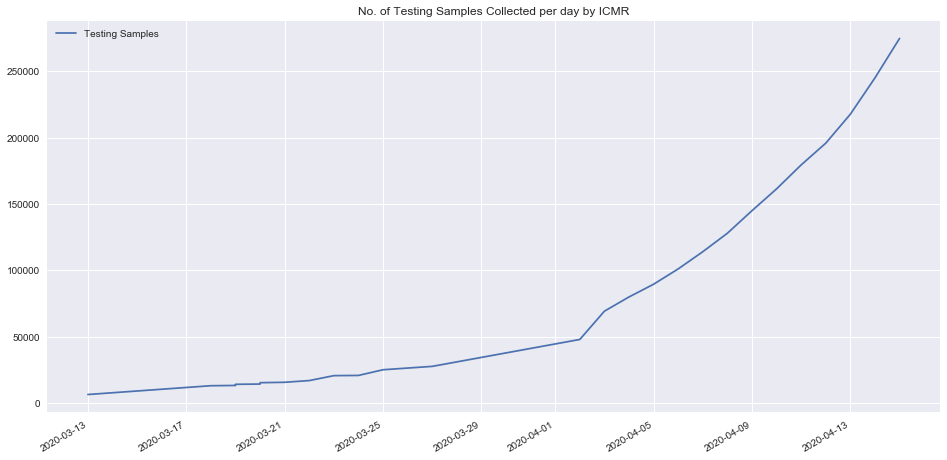

In [15]:
india_test_df.plot(title = 'No. of Testing Samples Collected per day by ICMR', figsize = (16,8))

In [16]:
# Combining with Statistics data
india_combined_data = india_test_df.join(india_data, how = 'right')

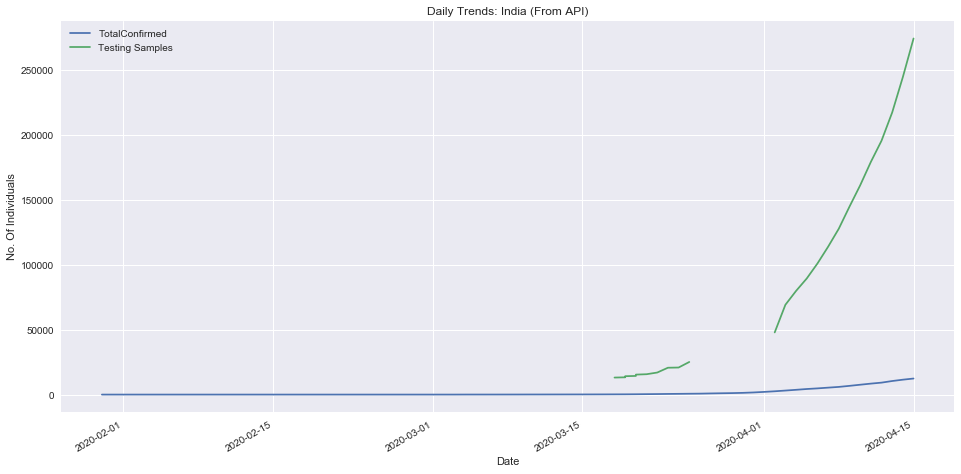

In [17]:
plot_daily(india_combined_data, ['TotalConfirmed', 'Testing Samples'], save='Cofirmed_testing_samples_')

### Growth Factor Of Virus
<p>
    The growth factor on day N is the number of confirmed cases on day N minus confirmed cases on day N-1 divided by the number of confirmed cases on day N-1 minus confirmed cases on day N-2.
     <br>Measure of whether the disease is growing or not. </p>
1. A value of greater than 1 = growth. <br>
2. Less than 1 = decline. <br>
3. A growth factor of 1 is the inflection point and at this point the disease is not increasing.

<p>
It can be seen that the growth of the virus <b>hasn't stabilised at the inflection point</b>.<br>
The Linear Regression on the Growth Factor seems to point to a downward trend in the Growth Factor but the margin of error is high.

In [18]:
def growth_factor(confirmed):
    confirmed_nminus1 = confirmed.shift(1, axis = 0)
    confirmed_nminus2 = confirmed.shift(2, axis = 0)
    return ((confirmed - confirmed_nminus1)/(confirmed_nminus1 - confirmed_nminus2))

In [45]:
india_growth_factor = growth_factor(india_data.TotalConfirmed[41:])
print(india_growth_factor.mean())

1.1825580688470232


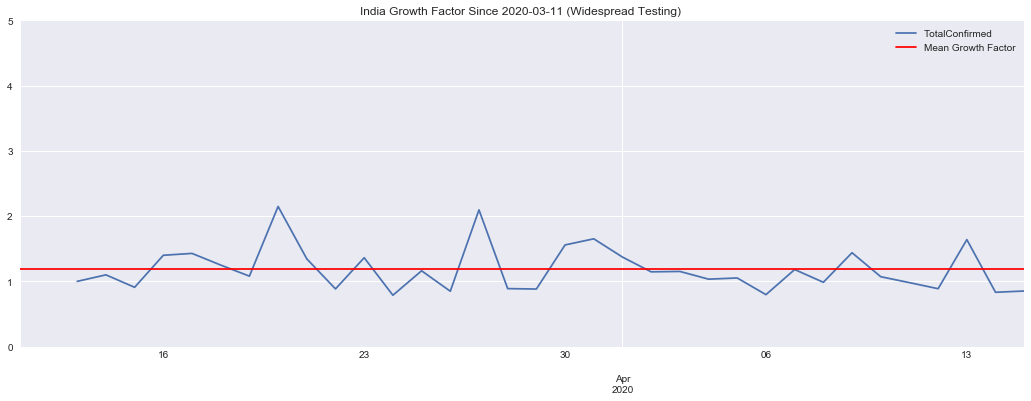

In [46]:
india_growth_factor.plot(grid = True, title = 'India Growth Factor Since 2020-03-11 (Widespread Testing) ', figsize = (18,6), ylim = (0,5))

plt.axhline(india_growth_factor.mean(), color = 'r', label='Mean Growth Factor')
plt.legend()
plt.savefig(path_graphs + 'India_Growth_Factor')

#### Linear Regression for Growth Factor.

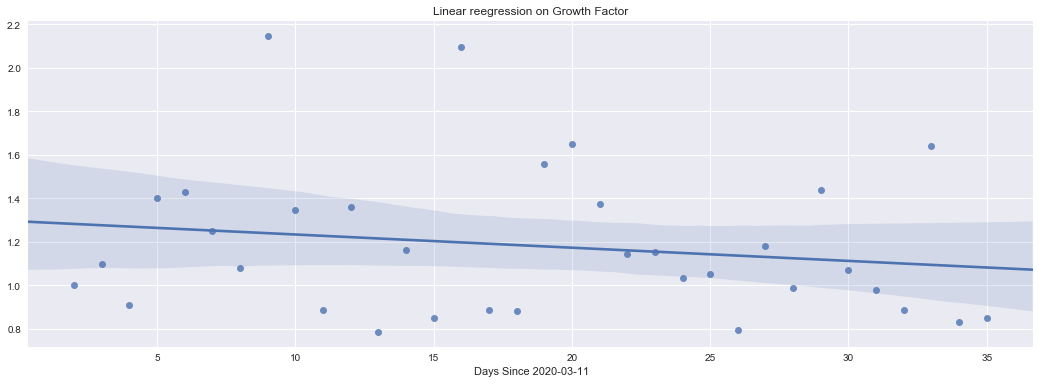

In [21]:
plt.figure(figsize = (18,6))
ax = sns.regplot(x = np.arange(len(india_growth_factor.index.tolist())) , y =india_growth_factor.to_list())
ax.set_title('Linear reegression on Growth Factor')
ax.set_xlabel(' Days Since 2020-03-11')
plt.savefig('India_Growth_Factor_Pred')
#ax.set_ybound(upper = 10)
# there is an outlier, causing problems (can just remove.)
# This is just a visualisation library, won't give you the equation, use plain linear reg to get line and plot it.

### Growth Ratio of Virus
The growth ratio on day N is the number of confirmed cases on day N divided by the number of confirmed cases on day N-1.</p>
Percentage Increase in total cumulative Cases from one day to the next.

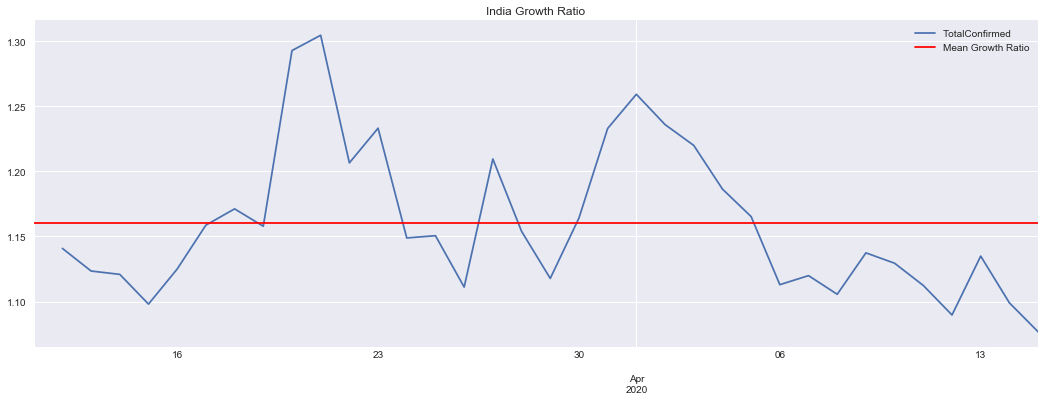

In [48]:
growth_ratio_india = india_data.TotalConfirmed[41:]/india_data.TotalConfirmed[41:].shift(1)

growth_ratio_india.plot(grid = True, title = 'India Growth Ratio', figsize = (18,6))
plt.axhline(growth_ratio_india.mean(), color = 'r', label='Mean Growth Ratio')
plt.legend()
plt.savefig(path_graphs + 'India_Growth_Ratio')

# 3. Modeling - Polynomial Regression
## TO DO : 
1. (Not good/complete - No Cross Validation etc.)
2. Add Growth Factor and Ratio as features.
3. Scale Data.
4. Use Regularized Regression, Ridge, Lasso.

In [83]:
#india_data

####  Using Growth Factor as a feature

In [134]:
# Imputing Missing values with mean of growth factor from 11-03 to present day.
# df_test_count.rename(columns = {'Country_Region': 'Country/Region', 'Province_State':'Province/State'}, inplace = True)


india_growth_factor_1 = growth_factor(india_data.TotalConfirmed[:])
india_growth_factor_1.replace(np.nan, india_growth_factor.mean(), inplace=True)
india_growth_factor_1.replace(np.inf, india_growth_factor.mean(), inplace = True)
india_growth_factor_1 = india_growth_factor_1.to_frame()

In [135]:
india_growth_factor_1.rename(columns = {'TotalConfirmed' : 'GrowthFactor'} , inplace=True)

In [142]:
# Merging the two dataframes
india_data = pd.concat([india_data, india_growth_factor_1], axis = 1)

In [75]:
#sns.regplot(x = np.arange(len(india_growth_factor_1.index.tolist())), y = india_growth_factor_1.to_list())
#plt.ylim((0,5))

####  Using Growth Ratio as a feature

In [56]:
growth_ratio_india_1 = india_data.TotalConfirmed[:]/india_data.TotalConfirmed[:].shift(1)

In [78]:
growth_ratio_india_1.replace(np.nan, 1, inplace = True)

In [140]:
growth_ratio_india_1 = growth_ratio_india_1.to_frame()
growth_ratio_india_1.rename(columns = {'TotalConfirmed' : 'GrowthRatio'} , inplace=True)

In [143]:
# Merging the two dataframes
india_data = pd.concat([india_data, growth_ratio_india_1], axis = 1)

#### Preparing Data 

In [157]:
x = india_data[['GrowthFactor', 'GrowthRatio']]
y = india_data['TotalConfirmed']

In [160]:
x.to_list

AttributeError: 'DataFrame' object has no attribute 'to_list'

In [65]:
# Filtering Dataset for India
india_cases_train, india_fatal_train = country_df('India', df_train_count)

# Preparing training and predict data.
x_train, y_cases, y_fatal = prepare_train_data(india_cases_train, india_fatal_train)

#x_test = np.arange(85).reshape(-1,1)

In [144]:
india_data

,DailyConfirmed,DailyDeceased,DailyRecovered,TotalConfirmed,TotalDeceased,TotalRecovered,GrowthFactor,GrowthRatio
2020-01-30,1,0,0,1,0,0,1.182558,1.000000
2020-01-31,0,0,0,1,0,0,1.182558,1.000000
2020-02-01,0,0,0,1,0,0,1.182558,1.000000
2020-02-02,1,0,0,2,0,0,1.182558,2.000000
2020-02-03,1,0,0,3,0,0,1.000000,1.500000
...,...,...,...,...,...,...,...,...
2020-04-11,854,40,186,8454,292,972,0.980482,1.112368
2020-04-12,758,42,114,9212,334,1086,0.887588,1.089662
2020-04-13,1243,27,112,10455,361,1198,1.639842,1.134933
2020-04-14,1035,37,167,11490,398,1365,0.832663,1.098996


In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [28]:
Input = [('poly', PolynomialFeatures(degree= 6)), ('lin_reg', LinearRegression())]

pipe = Pipeline(Input)

In [33]:
## Splitting into Train - Test sets
## 80 % Train, 20 % Test 

x_train_model = x_train[:65] 
y_train = y_cases[:65]
x_test = x_train[65:] 
y_test = y_cases[65:]

#### Predicting Confirmed Cases

In [35]:
pipe.fit(x_train_model, y_train)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [36]:
pipe.score(x_train_model, y_train)

0.9955583936114343

In [37]:
pipe.score(x_test, y_test)

0.8994294038897958

In [38]:
y_predicted = pipe.predict(x_train)

In [39]:
pipe.predict([[100]])

array([49940.74783454])

In [40]:
x_pred = np.arange(100).reshape(-1,1)

In [41]:
y_predicted = pipe.predict(x_pred)

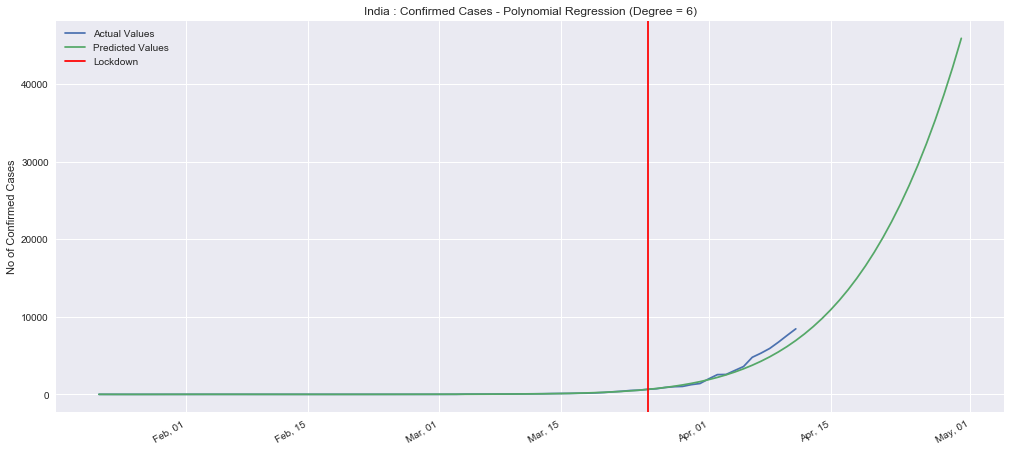

In [61]:
plot_actual_predicted('India', 'Confirmed Cases', y_cases, y_predicted, show_lockdown= True)

### Predicting Fatalities

In [381]:
# Getting labels for Fatalities
y_train = y_fatal[:65]
y_test = y_fatal[65:]

# fitting pipeline with fatalities

pipe.fit(x_train_model, y_train)

print(pipe.score(x_test, y_test))

# Predictions 

y_hat_fatal = pipe.predict(x_train)

0.8858853413257954


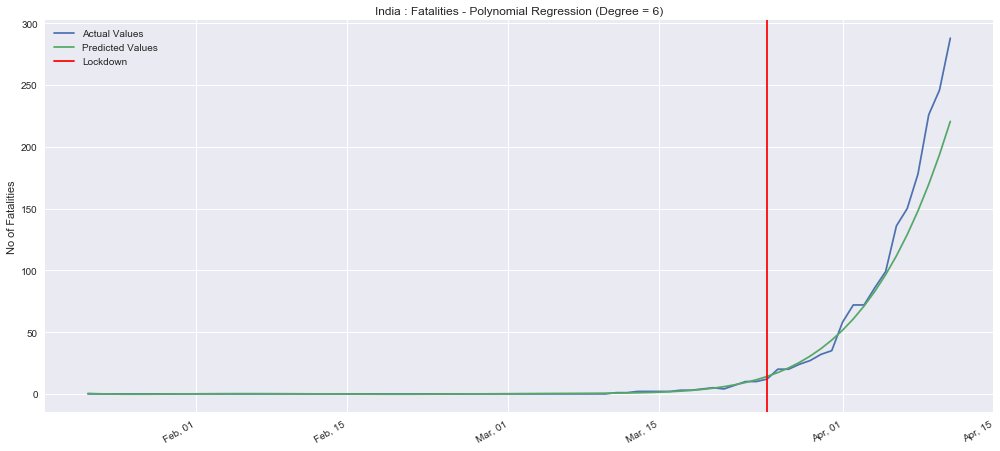

In [385]:
# Plotting these predictions

plot_actual_predicted('India', '2020-03-25', y_fatal, y_hat_fatal, cases = False)

### America

In [413]:
# getting filtered dataframes

us_cases, us_fatal = country_df('US', df_train_count)

# Preparing training and predict data.

x_train, y_case, y_fatal = prepare_train_data(us_cases, us_fatal)

# creating test data for 85 days.

x_test = np.arange(85).reshape(-1,1)

In [414]:
# Fitting polynomial reg pipeline for confirmed cases.

pipe.fit(x_train, y_case)

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=6, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [421]:
# Getting Predictions

y_conf_pred = pipe.predict(x_test)

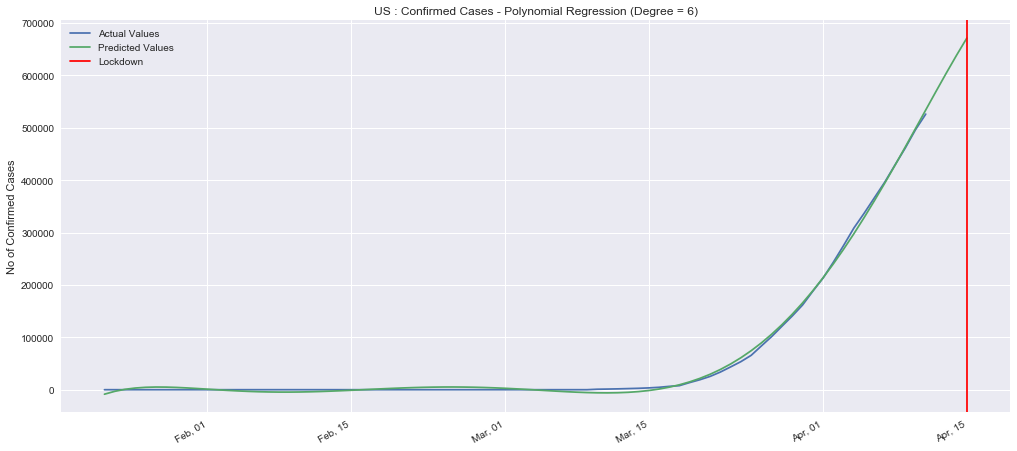

In [422]:
# Plotting these predictions 

plot_actual_predicted('US', '2020-04-15', y_case, y_conf_pred)